# PyGEM dynamical spinup using OGGM

Brandon S. Tober<br>

30MAY2025<br>

This notebook goes through dynamical spinup, using OGGM's workflows, but with PyGEM's mass balance model. We compare the differnece of flowline geometry before and after spinup.<br><br>
This notebook accompanies PyGEM's `run_spinup.py` script for demonstrative purposes. The resulting glacier directory data will resemble the state of [OGGM's level 4](https://tutorials.oggm.org/stable/notebooks/tutorials/building_the_prepro_gdirs.html#level-4) preprocessing, however having used PyGEM's mass balance model instead of OGGM's. If you have yet to run inversion, run through `run_inversion.ipynb` notebook before proceeding.

In [1]:
### imports ###
import logging
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from oggm import cfg, tasks, utils, workflow, graphics
from oggm.core.flowline import FileModel, SemiImplicitModel, FluxBasedModel
import pygem.pygem_modelsetup as modelsetup
from pygem import class_climate
from pygem.massbalance import PyGEMMassBalance, PyGEMMassBalance_wrapper
from pygem.oggm_compat import update_cfg
from pygem.shop import debris
from pygem.setup.config import ConfigManager
# instantiate ConfigManager
config_manager = ConfigManager()
# read the config
pygem_prms = config_manager.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                            # the appropriate location. If any errors occur, check this first.

# set some plotting defaults
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8
logging.getLogger('PIL.PngImagePlugin').setLevel(logging.WARNING)

cfg.initialize(logging_level='CRITICAL')
cfg.PATHS['working_dir'] = (
    f'{pygem_prms["root"]}/{pygem_prms["oggm"]["oggm_gdir_relpath"]}'
)


def get_colors_from_cmap(cmap_name, N):
    cmap = plt.get_cmap(cmap_name)
    return [cmap(i / (N - 1)) for i in range(N)]

# SETUP

In [2]:
# OGGM configuration settings
update_cfg({'continue_on_error': True}, 'PARAMS')
update_cfg({'use_multiprocessing': True}, 'PARAMS')

In [3]:
# Glacier Directory initialization for RGIId's of interest. Note, we'll demonstrate spinup with just one glacier here
main_glac_rgi = modelsetup.selectglaciersrgitable(glac_no=['06.00475'])        # testing with RGI region 6 since it's smaller
# initialize glacier directories (from existing gdirs, which should be at level 3 assuming inversion tasks were previously run)
gdirs = workflow.init_glacier_directories(
    main_glac_rgi['RGIId'].tolist()
);

1 glaciers in region 6 are included in this model run: ['00475']
This study is focusing on 1 glaciers in region [6]


In [4]:
# PyGEM setup - model datestable, climate data import, prior model parameters

# model dates
dt = modelsetup.datesmodelrun(
    startyear=1979, endyear=2019
)  # will have to cover the time period of inversion (2000-2019) and spinup (1979-~2010 by default). Note, 1940 startyear just in case we want to run spinup starting earlier.
# load climate data
ref_clim = class_climate.GCM(name='ERA5')

# Air temperature [degC]
temp, _ = ref_clim.importGCMvarnearestneighbor_xarray(
    ref_clim.temp_fn, ref_clim.temp_vn, main_glac_rgi, dt
)
# Precipitation [m]
prec, _ = ref_clim.importGCMvarnearestneighbor_xarray(
    ref_clim.prec_fn, ref_clim.prec_vn, main_glac_rgi, dt
)
# Elevation [m asl]
elev = ref_clim.importGCMfxnearestneighbor_xarray(
    ref_clim.elev_fn, ref_clim.elev_vn, main_glac_rgi
)
# Lapse rate [degC m-1]
lr, _ = ref_clim.importGCMvarnearestneighbor_xarray(
    ref_clim.lr_fn, ref_clim.lr_vn, main_glac_rgi, dt
)

# load prior regionally averaged modelprms (from Rounce et al. 2023)
priors_df = pd.read_csv(
    pygem_prms['root'] + '/Output/calibration/' + pygem_prms['calib']['priors_reg_fn']
)

# loop through gdirs and add `glacier_rgi_table`, `historical_climate`, `dates_table` and `modelprms` attributes to each glacier directory
for i, gd in enumerate(gdirs):
    # Select subsets of data
    gd.glacier_rgi_table = main_glac_rgi.loc[main_glac_rgi.index.values[i], :]
    # Add climate data to glacier directory (first inversion data)
    gd.historical_climate = {
        'elev': elev[i],
        'temp': temp[i, :],
        'tempstd': np.zeros(temp[i, :].shape),
        'prec': prec[i, :],
        'lr': lr[i, :],
    }
    gd.dates_table = dt

    # get modelprms from regional priors
    priors_idx = np.where(
        (priors_df.O1Region == gd.glacier_rgi_table['O1Region'])
        & (priors_df.O2Region == gd.glacier_rgi_table['O2Region'])
    )[0][0]
    tbias_mu = float(priors_df.loc[priors_idx, 'tbias_mean'])
    kp_mu = float(priors_df.loc[priors_idx, 'kp_mean'])
    gd.modelprms = {
        'kp': kp_mu,
        'tbias': tbias_mu,
        'ddfsnow': pygem_prms['calib']['MCMC_params']['ddfsnow_mu'],
        'ddfice': pygem_prms['calib']['MCMC_params']['ddfsnow_mu']
        / pygem_prms['sim']['params']['ddfsnow_iceratio'],
        'precgrad': pygem_prms['sim']['params']['precgrad'],
        'tsnow_threshold': pygem_prms['sim']['params']['tsnow_threshold'],
    }

# SPINUP
For spinup, we run the dynamical model attempting to find a dynamical state at the specified `spinup_start_yr` which leads to a match to the specified `minimise_for` variable (RGI area by default) at the specified `target_yr`.  As with inversion, we'll use PyGEM's mass balance model for this task (now passed as the `mb_model_historical` variable).  A departure from the way PyGEM's mass balaance model was passed to the inversion task, is that `run_dynamic_spinup` expects `mb_model_historical` to already be instantiated - thus, we cannot run all glaciers simultaneously using something like so:

```{python}
workflow.execute_entity_task(tasks.run_dynamic_spinup,
    gdirs,
    mb_model_historical = partial(PyGEMMassBalance_wrapper, fl_str="model_flowlines")
```

We have to instead loop through each gdir, and pass `mb_model_historical` as an instantiated mb model class. 

In [5]:
gd = gdirs[0]   # take 0th gdir from list of gdirs (we only have one anyways)

In [6]:
# perform OGGM dynamic spinup
tasks.run_dynamic_spinup(
    gd,
    # spinup_start_yr=1940,  # When to start the spinup
    target_yr=2000,  # The year at which we want to match area or volume. If None, gdir.rgi_date + 1 is used (the default)
    minimise_for='area',  # what target to match at the target_yr
    ye=2020,  # When the simulation should stop
    # model_flowline_filesuffix="_pygem_mb",  # The suffix of the model file to start from
    output_filesuffix='_dynamic_spinup_pygem_mb',
    store_fl_diagnostics=True,
    store_model_geometry=True,
    # first_guess_t_spinup = , could be passed as input argument for each step in the sampler based on prior tbias, current default first guess is -2
    mb_model_historical=PyGEMMassBalance_wrapper(
        gd, fl_str='model_flowlines', inversion_filter=True
    ),
)

# load flowline_diagnostics from spinup
f = gd.get_filepath('fl_diagnostics', filesuffix='_dynamic_spinup_pygem_mb')
with xr.open_dataset(f, group='fl_0') as ds_spn:
    # The data is compressed - it's a good idea to store it to memory
    # before playing with it
    ds_spn = ds_spn.load()

# instantiate flowline.FileModel object from model_geometry_dynamic_spinup
fmd_dynamic = FileModel(
    gd.get_filepath('model_geometry', filesuffix='_dynamic_spinup_pygem_mb')
)
# run FileModel to year 2000
fmd_dynamic.run_until(2000)
# write flowlines
gd.write_pickle(fmd_dynamic.fls, 'model_flowlines', filesuffix='_2000')
# add debris
debris.debris_binned(gd, fl_str='model_flowlines', filesuffix='_2000')
fls = gd.read_pickle('model_flowlines', filesuffix='_2000')

Let's also run the dynamical model from 2000-2020 without doing spinup (directly after inversion) to compare the impact of spinup on the glacier's dynamical state.

In [7]:
### RUN DYNAMICS ###
cls = gd.read_pickle('inversion_input')[-1]
th = cls['hgt'][-1]
vmin, vmax = cfg.PARAMS['free_board_marine_terminating']
water_level = utils.clip_scalar(0, th - vmax, th - vmin)
# mass balance model with evolving area
mbmod = PyGEMMassBalance(
    gd,
    gd.modelprms,
    gd.glacier_rgi_table,
    fls=gd.read_pickle('model_flowlines', filesuffix=''),
    inversion_filter=True,
)
glen_a = gd.get_diagnostics()['inversion_glen_a']
fs = gd.get_diagnostics()['inversion_fs']

# glacier dynamics model
ev_model = SemiImplicitModel(
    gd.read_pickle('model_flowlines', filesuffix=''),
    y0=2000,
    mb_model=mbmod,
    glen_a=glen_a,
    fs=fs,
    is_tidewater=gd.is_tidewater,
    water_level=water_level,
)
# run glacier dynamics model forward
_, ds_inv = ev_model.run_until_and_store(2020, fl_diag_path=True)
ds_inv = ds_inv[0]

Compare the glacier geometry at year 2000 with and without having done dynamical spinup

Text(0, 0.5, 'Elevation (masl)')

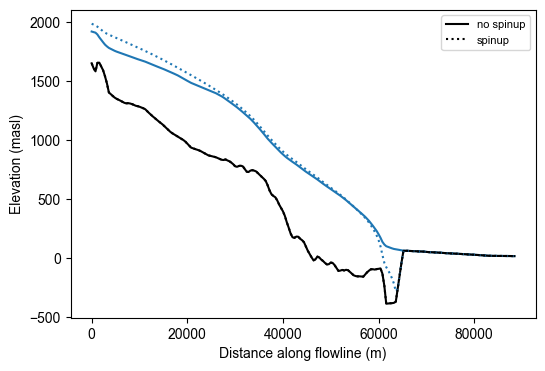

In [8]:
fig, ax = plt.subplots(1, figsize=(6,4))
fls_inv = gd.read_pickle('model_flowlines', filesuffix='')
fls_spn = gd.read_pickle('model_flowlines', filesuffix='_2000')

cls = fls_inv[-1]
x_inv = np.arange(cls.nx) * cls.dx * cls.map_dx

ax.plot(x_inv, cls.surface_h, c='tab:blue')
ax.plot(x_inv, cls.bed_h, 'k-', label='no spinup')

cls = fls_spn[-1]
x_spn = np.arange(cls.nx) * cls.dx * cls.map_dx
ax.plot(x_spn, cls.surface_h, c='tab:blue' ,ls=':')
ax.plot(x_spn, cls.bed_h, 'k', ls=':', label='spinup')
ax.legend()
ax.set_xlabel('Distance along flowline (m)')
ax.set_ylabel('Elevation (masl)')

Plot various components along glacier flowline (climatic mass balance, dhdt, flux divergence, initial thickness)

Text(0.5, 1.0, 'RGI60-06.00475')

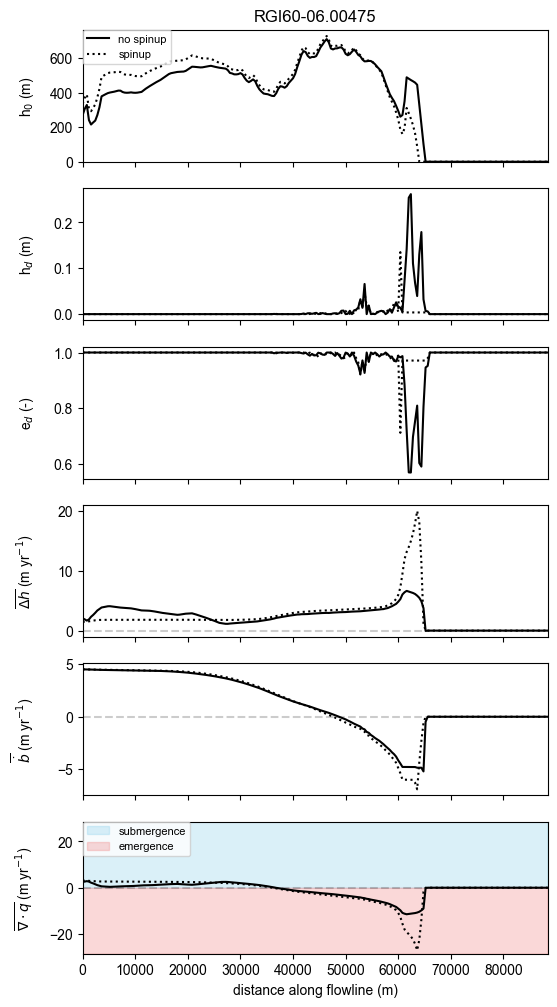

In [9]:
fig, ax = plt.subplots(6, sharex=True, figsize=(6, 12))
ax[0].plot(x_inv, ds_inv.sel(time=2000).thickness_m, 'k', label='no spinup')
ax[0].plot(x_spn, ds_spn.sel(time=2000).thickness_m, 'k:', label='spinup')

ax[1].plot(x_inv, fls_inv[0].debris_hd, 'k')
ax[1].plot(x_spn, fls_spn[0].debris_hd, 'k:')

ax[2].plot(x_inv, fls_inv[0].debris_ed, 'k')
ax[2].plot(x_spn, fls_spn[0].debris_ed, 'k:')

ax[3].plot(
    x_inv,
    np.nanmean(ds_inv.sel(time=slice('2000', '2020')).dhdt_myr.values, axis=0),
    'k',
)
ax[3].plot(
    x_spn,
    np.nanmean(ds_spn.sel(time=slice('2000', '2020')).dhdt_myr.values, axis=0),
    'k:',
)

ax[4].plot(
    x_inv,
    np.nanmean(ds_inv.sel(time=slice('2000', '2020')).climatic_mb_myr.values, axis=0),
    'k',
)
ax[4].plot(
    x_spn,
    np.nanmean(ds_spn.sel(time=slice('2000', '2020')).climatic_mb_myr.values, axis=0),
    'k:',
)

ax[5].plot(
    x_inv,
    -1
    * np.nanmean(
        ds_inv.sel(time=slice('2000', '2020')).flux_divergence_myr.values, axis=0
    ),
    'k',
)
ax[5].plot(
    x_spn,
    -1
    * np.nanmean(
        ds_spn.sel(time=slice('2000', '2020')).flux_divergence_myr.values, axis=0
    ),
    'k:',
)

ax[-1].set_xlabel('distance along flowline (m)')
ax[0].set_ylabel(r'h$_{0}$ (m)')
ax[0].set_ylim([0, ax[0].get_ylim()[1]])
ax[1].set_ylabel(r'h$_{d}$ (m)')
ax[2].set_ylabel(r'e$_{d}$ (-)')
ax[3].set_ylabel(r'$\overline{\Delta h}$ (m yr$^{-1}$)')
ax[3].axhline(0, color='k', alpha=0.2, ls='--')
ax[4].set_ylabel(r'$\overline{\dot{b}}$ (m yr$^{-1}$)')
ax[4].axhline(0, color='k', alpha=0.2, ls='--')
ax[5].set_ylabel(r'$\overline{\nabla \cdot q}$ (m yr$^{-1}$)')
ax[5].axhline(0, color='k', alpha=0.2, ls='--')
ylims = ax[5].get_ylim()
ax[0].set_xlim([min(x_inv.min(), x_spn.min()), max(x_inv.max(), x_spn.max())])
ylims = [-np.max(np.abs(ylims)), np.max(np.abs(ylims))]
x = np.arange(ax[5].get_xlim()[0], ax[5].get_xlim()[1], 1)
ax[5].fill_between(x, 0, ylims[1], color='skyblue', alpha=0.3, label='submergence')
ax[5].fill_between(x, 0, ylims[0], color='lightcoral', alpha=0.3, label='emergence')
ax[5].set_ylim(ylims)
ax[5].legend(borderaxespad=0, loc='upper left')
ax[0].legend(borderaxespad=0, loc='upper left')

for a in ax:
    a.yaxis.set_label_coords(-0.1, 0.5)
ax[0].set_title(f'{gd.rgi_id}')

Text(0.5, 1.0, 'RGI60-06.00475')

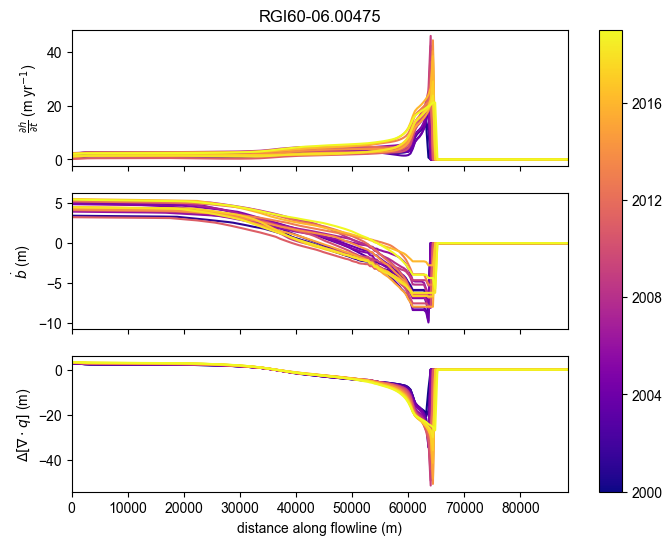

In [10]:
# Get number of years and color map
years = ds_spn.sel(time=slice('2000', '2020')).time.values.astype(int)

# Set up figure and axis
fig, ax = plt.subplots(3, figsize=(8, 6), sharex=True)

# Create colormap and normalization
cmap = plt.get_cmap('plasma')
norm = mcolors.Normalize(vmin=years[0], vmax=years[-1])
scalar_map = cmx.ScalarMappable(norm=norm, cmap=cmap)

# Plot each line with corresponding color
for i, year in enumerate(years):
    ax[0].plot(
        x_spn,
        ds_spn.sel(time=slice('2000', '2020')).dhdt_myr.values[i, :],
        c=scalar_map.to_rgba(year),
    )
    ax[1].plot(
        x_spn,
        ds_spn.sel(time=slice('2000', '2020')).climatic_mb_myr.values[i, :],
        c=scalar_map.to_rgba(year),
    )
    ax[2].plot(
        x_spn,
        -1 * ds_spn.sel(time=slice('2000', '2020')).flux_divergence_myr.values[i, :],
        c=scalar_map.to_rgba(year),
    )

# Add colorbar with integer year ticks
cbar = fig.colorbar(scalar_map, ax=ax)

# Set colorbar ticks to integers, spaced reasonably
tick_step = max(1, len(years) // 5)  # Adjust number of ticks if needed
cbar.set_ticks(years[::tick_step])
cbar.set_ticklabels(years[::tick_step])

# Axis labels
ax[0].set_ylabel(r'$\frac{\partial h}{\partial t}$ (m yr$^{-1}$)')
ax[1].set_ylabel(r'$\dot{b}$ (m)')
ax[2].set_ylabel(r'$\Delta [ \nabla \cdot q ]$ (m)')
ax[2].set_xlabel('distance along flowline (m)')
ax[0].set_xlim([x_spn.min(), x_spn.max()])
ax[0].set_title(f'{gd.rgi_id}')

We now have a workflow to run dynamical spinup using PyGEM's mass balance model.  Taking this workfow, can run dynamical spinup over glaciers of interest in parallel using a separate script `run_spinup.py`:

E.g.
```{python}
run_spinup -rgi_glac_number 1.00570 -target_yr 2000
```

or for an entire region:
```{bash}
run_spinup -rgi_region01 1 -target_yr 2000
```

# MORE:
Check that dynamical spinup run outputs agree with a cold-start (what we'd do when running model calibration following spinup)

## SETUP

Take one of the gdirs - grab model_flowlines from model_geometry produced by dynamic spinup to run dynamical model from "cold-start" over 2000-2020 period

In [11]:
# instantiate flowline.FileModel object from model_geometry_dynamic_spinup
fmd_dynamic = FileModel(
    gd.get_filepath('model_geometry', filesuffix='_dynamic_spinup_pygem_mb')
)
# run FileModel to year 2000 (it will be initialized at `spinup_start_yr`)
print(f'Flowline model for {gd.rgi_id} initialized at year {fmd_dynamic.yr}')
# Bring it to year 2000
fmd_dynamic.run_until(2000)
# write flowlines
gd.write_pickle(fmd_dynamic.fls, 'model_flowlines', filesuffix='_2000')
# add debris
debris.debris_binned(gd, fl_str='model_flowlines', filesuffix='_2000');

Flowline model for RGI60-06.00475 initialized at year 1980.0


## COLD START RUN

In [12]:
### RUN DYNAMICS ###
cls = gd.read_pickle('inversion_input')[-1]
th = cls['hgt'][-1]
vmin, vmax = cfg.PARAMS['free_board_marine_terminating']
water_level = utils.clip_scalar(0, th - vmax, th - vmin)
# mass balance model with evolving area
mbmod = PyGEMMassBalance(
    gd,
    gd.modelprms,
    gd.glacier_rgi_table,
    fls=gd.read_pickle('model_flowlines', filesuffix='_2000'),
    inversion_filter=True,
)
glen_a = gd.get_diagnostics()['inversion_glen_a']
fs = gd.get_diagnostics()['inversion_fs']

# glacier dynamics model
ev_model = SemiImplicitModel(
    gd.read_pickle('model_flowlines', filesuffix='_2000'),
    y0=2000,
    mb_model=mbmod,
    glen_a=glen_a,
    fs=fs,
    is_tidewater=gd.is_tidewater,
    water_level=water_level,
)

# run glacier dynamics model forward
_, ds_cs = ev_model.run_until_and_store(2020, fl_diag_path=True)
ds_cs = ds_cs[0]

# SPINUP RUN

In [13]:
# load flowline_diagnostics from spinup
f = gd.get_filepath('fl_diagnostics', filesuffix='_dynamic_spinup_pygem_mb')
with xr.open_dataset(f, group='fl_0') as ds_spn:
    # The data is compressed - it's a good idea to store it to memory
    # before playing with it
    ds_spn = ds_spn.load()

# COMPARISON
Compare the cold start (flowlines taken after spinup) components with the components from dynamical spinup directly to ensure that we can safely store flowlines after spinup and start the dynamical model back up again from the same state.

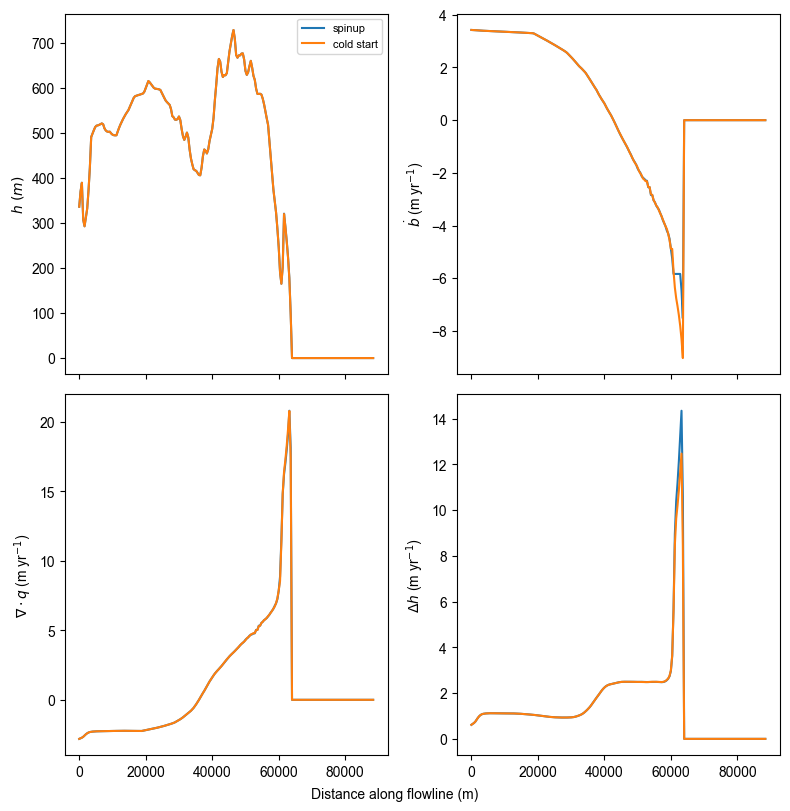

In [14]:
fig, ax = plt.subplots(2,2, figsize=(8,8), sharex=True)

ax[0,0].plot(ds_spn.dis_along_flowline, ds_spn.sel(time=2001).thickness_m, label='spinup')
ax[0,0].plot(ds_cs.dis_along_flowline, ds_cs.sel(time=2001).thickness_m, label='cold start')
ax[0,0].legend()

ax[1,0].plot(
    ds_spn.dis_along_flowline.values,
    ds_spn.sel(time=2001).flux_divergence_myr.values,
    label='spinup',
)
ax[1,0].plot(
    ds_cs.dis_along_flowline.values,
    ds_cs.sel(time=2001).flux_divergence_myr.values,
    label='cold start',
)


ax[0,1].plot(
    ds_spn.dis_along_flowline, ds_spn.sel(time=2001).climatic_mb_myr, label='spinup'
)
ax[0,1].plot(
    ds_cs.dis_along_flowline, ds_cs.sel(time=2001).climatic_mb_myr, label='cold start'
)

ax[1,1].plot(ds_spn.dis_along_flowline, ds_spn.sel(time=2001).dhdt_myr, label='spinup')
ax[1,1].plot(ds_cs.dis_along_flowline, ds_cs.sel(time=2001).dhdt_myr, label='cold start')

ax[1,1].set_ylabel(r'$\Delta h$ (m yr$^{-1}$)')
ax[0,1].set_ylabel(r'$\dot{b}$ (m yr$^{-1}$)')
ax[0,0].set_ylabel(r'$h \ (m)$')
ax[1,0].set_ylabel(r'$\nabla \cdot q$ (m yr$^{-1}$)')

fig.text(0.5,0,'Distance along flowline (m)', ha='center', va='center')
fig.tight_layout()

Note, there may be some small unavoidable discrepancy between the "spinup" and "cold start" dynamics due to numberical instabilities.